# Notebook to visualize simulated Alpine-3D grids
## First, import packages

In [1]:
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import glob
import moviepy.editor as mpy
from palettable.colorbrewer.sequential import *
from palettable.colorbrewer.diverging import *

## Add netCDF file path, define grid variable to plot, and time step.

In [2]:
nc_path = "../output/grids/a3d_grids.nc"
ds = xr.open_dataset(nc_path)
tgt_time = "1980-01-01T12:00:00" # Specific timestep
tgt_time_ind = -1 # Last timestep
var_plot = "swe"
ds

<xarray.Dataset>
Dimensions:                (easting: 168, northing: 107, time: 732)
Coordinates:
  * time                   (time) datetime64[ns] 1980-01-01T12:00:00 ... 1981-01-01
  * northing               (northing) float32 -109000.0 -108000.0 ... -3000.0
  * easting                (easting) float32 -1542000.0 ... -1375000.0
Data variables:
    dw                     (time, northing, easting) float32 ...
    snd                    (time, northing, easting) float32 ...
    rlds                   (time, northing, easting) float32 ...
    rsds                   (time, northing, easting) float32 ...
    swe                    (time, northing, easting) float32 ...
    ta                     (time, northing, easting) float32 ...
    ws                     (time, northing, easting) float32 ...
    VW_DRIFT               (time, northing, easting) float32 ...
    WINDEROSIONDEPOSITION  (time, northing, easting) float32 ...
Attributes:
    date_created:              2020-06-17
    creator_name:              erke2265
    source:                    MeteoIO-2.81
    history:                   2020-06-18T02:32:26Z, erke2265@shas0347.rc.int...
    keywords_vocabulary:       AGU Index Terms
    keywords:                  Cryosphere, Mass Balance, Energy Balance, Atmo...
    title:                     Gridded data for various parameters and timesteps
    institution:               colorado.edu
    product_version:           1.0
    Conventions:               CF-1.6,ACDD-1.3
    standard_name_vocabulary:  CF-1.6
    cdm_data_type:             Grid
    geospatial_bounds_crs:     EPSG:3031
    geospatial_bounds:         Polygon ((-1542000.0000000000 -109000.00000000...

## Load coastlines data

In [3]:
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

## Plot grid

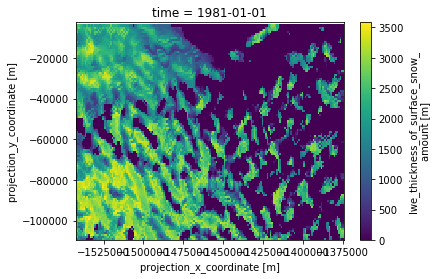

In [4]:
# Plot on specific day
# ds.sel(time=tgt_time)[var_plot].plot()

# Plot last timestep
ds.isel(time=tgt_time_ind)[var_plot].plot()

## Plot map

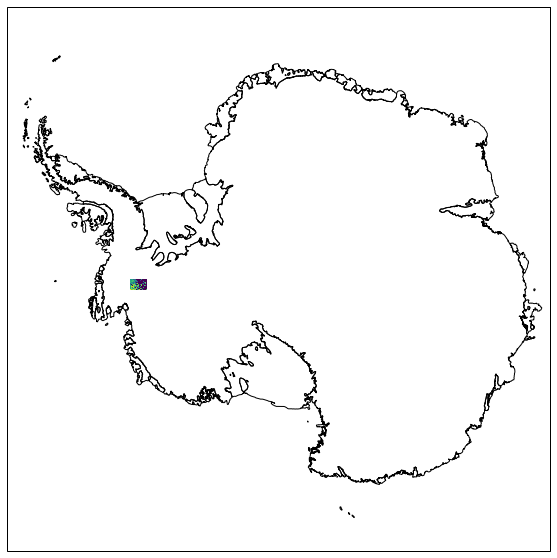

In [5]:
# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(10, 10))

# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree()) # Full ice sheet
# axs.set_extent((-110, -70, -85, -70), ccrs.PlateCarree()) # Zoom in on Alpine-3D domain
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# Define easting and northings
northings = ds.sel(time=tgt_time)[var_plot]['northing']
eastings = ds.sel(time=tgt_time)[var_plot]['easting']

# Plot map
mesh = plt.pcolormesh(eastings, northings, ds.isel(time=tgt_time_ind)[var_plot])

## Plot last timestep minus first timestep

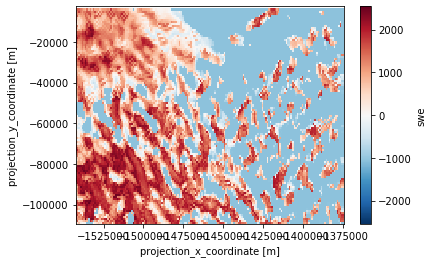

In [6]:
diff = ds[var_plot].isel(time=-1) - ds[var_plot].isel(time=0)
diff.plot()

# Make a movie of SWE and SMB

In [9]:
# Settings
var = 'swe'
fps = 30
file_name = "movie"

# Clear old images, gifs, and movies
!mkdir -p movie_frame
!rm -f movie.gif
!rm -f movie.mp4

# Calculate colorbar limits
diff_magnitude = np.abs(ds[var] - ds.isel(time=0)[var])
diff_lim = diff_magnitude.max()
lim = ds[var].max()

for j in range(0, len(ds['time']), 2):
# for j in range(0, 2):
    
    # Figure settings
    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    time = str(ds['time'][j].values)
    
    # SWE
    swe = ax1.pcolormesh(eastings/1000, northings/1000, ds.isel(time=j)[var], \
                         cmap=Blues_9.mpl_colormap, vmin=0, vmax=lim)
    fig1.colorbar(swe, ax=ax1)
    ax1.set_title("SWE [mm]: " + time[0:10])
    
    # Change in SWE
    dswe = ax2.pcolormesh(eastings/1000, northings/1000, \
                          ds.isel(time=j)[var] - ds.isel(time=0)[var], \
                          cmap=RdBu_11.mpl_colormap, \
                          vmin=-diff_lim, vmax=diff_lim)
    
    fig1.colorbar(dswe, ax=ax2)
    ax2.set_title("Accumulated SMB [mm]: " + time[0:10])
    
    #Save Figure with image number zero padding 
    if j < 10:
        plt.savefig("movie_frame/frame_00" + str(j) + ".png", dpi=100)
    elif j < 100 and j > 9:
        plt.savefig("movie_frame/frame_0" + str(j) + ".png", dpi=100)
    else:
        plt.savefig("movie_frame/frame_" + str(j) + ".png", dpi=100)
    plt.close()
    
# Make a .mp4 movie and gif
file_list = sorted(glob.glob('movie_frame/*.png'))
clip = mpy.ImageSequenceClip(file_list, fps=fps)
clip.write_videofile(file_name+'.mp4')
clip.write_gif(file_name+'.gif')

# Clear images
!rm -rf movie_frame

Moviepy - Building video movie.mp4.
Moviepy - Writing video movie.mp4



t:   1%|          | 3/366 [00:00<00:22, 16.02it/s, now=None]  

Moviepy - Done !
Moviepy - video ready movie.mp4
MoviePy - Building file movie.gif with imageio.


## Plot timeseries of integrated SMB

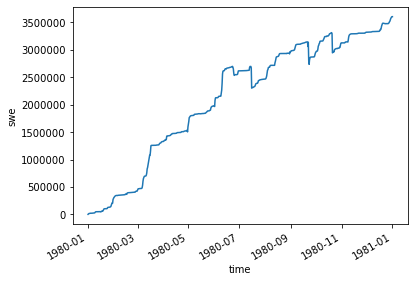

In [8]:
swe0 = ds['swe'].sum(dim='northing').sum(dim='easting').isel(time=0)
swe_t = ds['swe'].sum(dim='northing').sum(dim='easting') - swe0
swe_t.plot()